# May 11-14,16, 2022: Idea1: don't care labels: create and train a model

Write your own `loss_function` to ignore padded time steps while computing loss and training/evaluating. 

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
import tensorflow.keras.backend as K
# import tensorflow_addons as tfa
import pickle, time, random
import neural_structured_learning as nsl
from tqdm import tqdm
import json
from itertools import combinations, product
from operator import add
import copy

# explanation tools
import shap

# plotting
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import hypernetx as hnx
from networkx import fruchterman_reingold_layout as layout

# nilearn
from nilearn import image
from nilearn import masking
from nilearn import plotting

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'explainable-ai')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/may22"

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils as dataset_utils
import helpers.base_model as base_model
import helpers.model_definitions as model_definitions
import data.emoprox2.scripts.stimulus_utils as stimulus_utils

# select the GPU to be used
gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_memory_growth(gpus[1], True)
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# print the JS visualization code to the notebook
shap.initjs()

2022-05-16 14:44:16.603000: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-05-16 14:44:18.601300: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-05-16 14:44:18.608238: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-05-16 14:44:18.608410: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-05-16 14:44:18.608426: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
202

## training and testing datasets

In [2]:
def get_data(data, subject_list):
    X = [] 
    y = []
    Xlen = [] 
    global MASK

    for subject in subject_list:
        X += data[subject]['X']
        y += data[subject]['y']
        Xlen += [i.shape[0] for i in data[subject]['X']]

    X_padded = tf.keras.preprocessing.sequence.pad_sequences(
        X, 
        padding="post",
        dtype='float', 
        value=MASK
    )
    
    y_padded = tf.keras.preprocessing.sequence.pad_sequences(
        y, 
        padding="post",
        dtype='float',
        value=MASK
    )
    # y_padded = tf.convert_to_tensor(y)

    return X_padded, y_padded, Xlen

In [3]:
'''
target stimuli
'''
APPR, RETR = 1, 0
MASK = 0.5

data_file = f"{proj_dir}/data/emoprox2/idea1_data.pkl"
with open(data_file, 'rb') as f:
    data = pickle.load(f)

'''
(hyper)-parameters
'''
class ARGS(): pass
args = ARGS()

args.SEED = 74

# data args
args.num_subjects = len(data.keys())
args.num_train = args.num_subjects // 2
args.num_test = args.num_subjects - args.num_train

# model args
args.num_units = 32
args.num_classes = 2 # for binary classification
args.l2 = 1e-2
args.dropout = 0.8
args.learning_rate = 4e-4

args.num_epochs = 50
args.validation_split = 0.2
args.batch_size = 64

args.return_sequences = True

'''
generate dataset for the model
'''
subject_list = list(data.keys())
random.Random(args.SEED).shuffle(subject_list)

train_list = subject_list[:args.num_train]
test_list = subject_list[args.num_train:]

(X_train, y_train, 
 len_train) = get_data(data, train_list)
(X_test, y_test, 
 len_test) = get_data(data, test_list)

print(X_train.shape, y_train.shape)

(10154, 8, 85) (10154, 8)


## model: GRU

In [4]:
class CustomSCCE(tf.keras.losses.Loss):
    '''
    Custom Sparse Categorical Crossentropy
    '''
    def __init__(self, name='custom_scce'):
        super().__init__(name=name)
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, 
            reduction=tf.keras.losses.Reduction.NONE
        )
    
    def call(self, y_true, y_pred):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(y_true != MASK, tf.float32)
        loss *= mask
        # average on non-zeros
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [5]:
tf.random.set_seed(args.SEED)
regularizer = tf.keras.regularizers.l2(l2=args.l2) 
optimizer = tf.keras.optimizers.Adam(learning_rate=args.learning_rate)

model_file = f"{results_dir}/emoprox_full_data/models/GRU_classifier_idea1"
history_file = f"{results_dir}/emoprox_full_data/models/GRU_classifier_idea1_history"
if os.path.exists(model_file):
    # load the model
    model = tf.keras.models.load_model(model_file)
    history = json.load(open(f"{history_file}", 'r'))
else:
    # build, train, and save the model
    '''
    build model
    '''
    model = model_definitions.get_GRU_classifier_model(
        X_train, 
        args, 
        regularizer, 
        mask_value=MASK, 
        return_sequences=True)

    '''
    train model
    '''
    model.compile(
        loss=CustomSCCE(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    then = time.time()
    history = model.fit(
        x=X_train, 
        y=y_train,
        batch_size=args.batch_size, 
        epochs=args.num_epochs, 
        verbose=1,
        callbacks=tf.keras.callbacks.EarlyStopping(patience=5),
        validation_split=args.validation_split, 
        shuffle=True)
    print('--- train time =  %0.4f seconds ---' %(time.time() - then))

    '''
    save model
    '''
    model.save(model_file)
    history = history.history
    json.dump(history, open(f"{history_file}", 'w'))
    
# evaluate the model
eval_hist = model.evaluate(X_test, y_test)

2022-05-16 14:55:45.028432: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-16 14:55:45.030559: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-05-16 14:55:45.031422: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 1
2022-05-16 14:55:45.031516: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-05-16 14:55:45.442030: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect St

Epoch 1/50


2022-05-16 14:55:47.168169: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


  5/127 [>.............................] - ETA: 4s - loss: 1.8114 - sparse_categorical_accuracy: 0.4806 

2022-05-16 14:55:47.488060: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


127/127 [==============================] - 7s 44ms/step - loss: 1.4666 - sparse_categorical_accuracy: 0.5119 - val_loss: 1.1572 - val_sparse_categorical_accuracy: 0.5542
Epoch 2/50
127/127 [==============================] - 5s 43ms/step - loss: 1.0002 - sparse_categorical_accuracy: 0.5335 - val_loss: 0.8402 - val_sparse_categorical_accuracy: 0.5748
Epoch 3/50
127/127 [==============================] - 5s 42ms/step - loss: 0.7676 - sparse_categorical_accuracy: 0.5547 - val_loss: 0.6847 - val_sparse_categorical_accuracy: 0.5817
Epoch 4/50
127/127 [==============================] - 5s 42ms/step - loss: 0.6551 - sparse_categorical_accuracy: 0.5606 - val_loss: 0.6085 - val_sparse_categorical_accuracy: 0.5896
Epoch 5/50
127/127 [==============================] - 5s 42ms/step - loss: 0.6015 - sparse_categorical_accuracy: 0.5622 - val_loss: 0.5725 - val_sparse_categorical_accuracy: 0.5890
Epoch 6/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5741 - sparse_categorical_acc

2022-05-16 14:59:17.082528: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/govindas/explainable-ai/results/emoprox_full_data/models/GRU_classifier_idea1/assets
321/321 [==============================] - 3s 9ms/step - loss: 0.5323 - sparse_categorical_accuracy: 0.5798


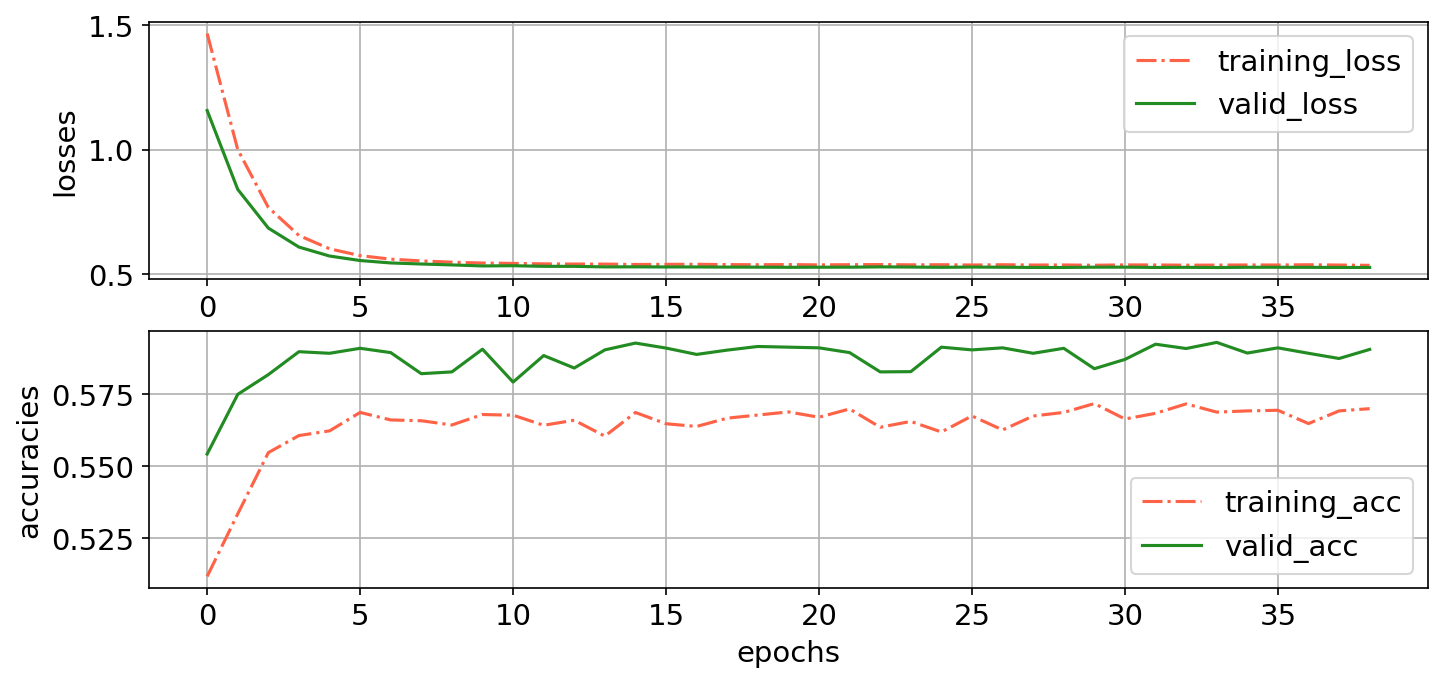

In [21]:
fig, axs = plt.subplots(
    nrows=2, ncols=1,
    figsize=(11,5),
    dpi=150
)

ax = axs[0]
ax.plot(history['loss'], color='tomato', linestyle='-.', label='training_loss')
ax.plot(history['val_loss'], color='forestgreen', label='valid_loss')
ax.set_ylabel(f"losses")
ax.set_xlabel(f"epochs")
ax.legend()
ax.grid(True)

ax = axs[1]
ax.plot(history['sparse_categorical_accuracy'], color='tomato', linestyle='-.', label='training_acc')
ax.plot(history['val_sparse_categorical_accuracy'], color='forestgreen', label='valid_acc')
ax.set_ylabel(f"accuracies")
ax.set_xlabel(f"epochs")
ax.legend()
ax.grid(True)

In [25]:
num_null_models = 10
null_eval_hists_file = f"{results_dir}/emoprox_full_data/models/GRU_classifier_null_eval_hists_idea1"
if not os.path.exists(null_eval_hists_file):
    null_eval_hists = []
    for idx_null in tqdm(np.arange(num_null_models)):
        # build, train, and save the model
        '''
        build model
        '''
        null_model = model_definitions.get_GRU_classifier_model(
            X_train, 
            args, 
            regularizer, 
            mask_value=MASK, 
            return_sequences=True
        )

        '''
        train model
        '''
        null_model.compile(
            loss=CustomSCCE(),
            optimizer=optimizer,
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
        )

        then = time.time()
        null_history = null_model.fit(
            x=X_train, 
            y=np.random.randint(low=0, high=2, size=(y_train.shape)).astype(float),
            batch_size=args.batch_size, 
            epochs=args.num_epochs, 
            verbose=1,
            callbacks=tf.keras.callbacks.EarlyStopping(patience=5),
            validation_split=args.validation_split, 
            shuffle=True)
        print('--- train time =  %0.4f seconds ---' %(time.time() - then))

        # evaluate the model
        null_eval_hists.append(null_model.evaluate(X_test, y_test, verbose=0)[1])
    
    # save null evaluations
    with open(null_eval_hists_file, 'wb') as f:
        pickle.dump(null_eval_hists, f)
else:
    # load null evaluations
    with open(null_eval_hists_file, 'rb') as f:
        null_eval_hists = pickle.load(f) 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/50
127/127 [==============================] - 7s 44ms/step - loss: 0.8297 - sparse_categorical_accuracy: 0.5018 - val_loss: 0.5748 - val_sparse_categorical_accuracy: 0.5027
Epoch 2/50
127/127 [==============================] - 5s 41ms/step - loss: 0.5603 - sparse_categorical_accuracy: 0.5021 - val_loss: 0.5495 - val_sparse_categorical_accuracy: 0.5098
Epoch 3/50
127/127 [==============================] - 5s 40ms/step - loss: 0.5498 - sparse_categorical_accuracy: 0.5023 - val_loss: 0.5461 - val_sparse_categorical_accuracy: 0.4964
Epoch 4/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5478 - sparse_categorical_accuracy: 0.4997 - val_loss: 0.5449 - val_sparse_categorical_accuracy: 0.5020
Epoch 5/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5471 - sparse_categorical_accuracy: 0.4967 - val_loss: 0.5445 - val_sparse_categorical_accuracy: 0.4990
Epoch 6/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5465 - sparse_cate

 10%|█         | 1/10 [02:11<19:47, 131.89s/it]

Epoch 1/50
127/127 [==============================] - 7s 44ms/step - loss: 0.8306 - sparse_categorical_accuracy: 0.5017 - val_loss: 0.5749 - val_sparse_categorical_accuracy: 0.4932
Epoch 2/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5604 - sparse_categorical_accuracy: 0.5011 - val_loss: 0.5496 - val_sparse_categorical_accuracy: 0.5043
Epoch 3/50
127/127 [==============================] - 5s 41ms/step - loss: 0.5499 - sparse_categorical_accuracy: 0.4975 - val_loss: 0.5462 - val_sparse_categorical_accuracy: 0.4993
Epoch 4/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5477 - sparse_categorical_accuracy: 0.5019 - val_loss: 0.5449 - val_sparse_categorical_accuracy: 0.5049
Epoch 5/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5470 - sparse_categorical_accuracy: 0.5020 - val_loss: 0.5448 - val_sparse_categorical_accuracy: 0.4983
Epoch 6/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5466 - sparse_cate

 20%|██        | 2/10 [03:36<13:52, 104.05s/it]

Epoch 1/50
127/127 [==============================] - 7s 44ms/step - loss: 0.8306 - sparse_categorical_accuracy: 0.4973 - val_loss: 0.5751 - val_sparse_categorical_accuracy: 0.5031
Epoch 2/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5606 - sparse_categorical_accuracy: 0.5010 - val_loss: 0.5494 - val_sparse_categorical_accuracy: 0.5042
Epoch 3/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5499 - sparse_categorical_accuracy: 0.5001 - val_loss: 0.5461 - val_sparse_categorical_accuracy: 0.4942
Epoch 4/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5479 - sparse_categorical_accuracy: 0.4974 - val_loss: 0.5449 - val_sparse_categorical_accuracy: 0.5013
Epoch 5/50
127/127 [==============================] - 5s 43ms/step - loss: 0.5470 - sparse_categorical_accuracy: 0.5004 - val_loss: 0.5449 - val_sparse_categorical_accuracy: 0.5002
Epoch 6/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5466 - sparse_cate

 30%|███       | 3/10 [05:17<11:57, 102.51s/it]

Epoch 1/50
127/127 [==============================] - 7s 44ms/step - loss: 0.8293 - sparse_categorical_accuracy: 0.4998 - val_loss: 0.5747 - val_sparse_categorical_accuracy: 0.4997
Epoch 2/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5602 - sparse_categorical_accuracy: 0.4984 - val_loss: 0.5495 - val_sparse_categorical_accuracy: 0.4969
Epoch 3/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5500 - sparse_categorical_accuracy: 0.4976 - val_loss: 0.5458 - val_sparse_categorical_accuracy: 0.5002
Epoch 4/50
127/127 [==============================] - 5s 43ms/step - loss: 0.5477 - sparse_categorical_accuracy: 0.5001 - val_loss: 0.5449 - val_sparse_categorical_accuracy: 0.5012
Epoch 5/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5471 - sparse_categorical_accuracy: 0.5023 - val_loss: 0.5445 - val_sparse_categorical_accuracy: 0.5033
Epoch 6/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5466 - sparse_cate

 40%|████      | 4/10 [07:40<11:52, 118.70s/it]

Epoch 1/50
127/127 [==============================] - 7s 44ms/step - loss: 0.8302 - sparse_categorical_accuracy: 0.5017 - val_loss: 0.5750 - val_sparse_categorical_accuracy: 0.4984
Epoch 2/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5601 - sparse_categorical_accuracy: 0.5041 - val_loss: 0.5496 - val_sparse_categorical_accuracy: 0.5059
Epoch 3/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5500 - sparse_categorical_accuracy: 0.5015 - val_loss: 0.5457 - val_sparse_categorical_accuracy: 0.5039
Epoch 4/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5476 - sparse_categorical_accuracy: 0.5033 - val_loss: 0.5455 - val_sparse_categorical_accuracy: 0.5043
Epoch 5/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5471 - sparse_categorical_accuracy: 0.4993 - val_loss: 0.5446 - val_sparse_categorical_accuracy: 0.4991
Epoch 6/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5466 - sparse_cate

 50%|█████     | 5/10 [09:15<09:10, 110.17s/it]

Epoch 1/50
127/127 [==============================] - 7s 44ms/step - loss: 0.8301 - sparse_categorical_accuracy: 0.5045 - val_loss: 0.5756 - val_sparse_categorical_accuracy: 0.4891
Epoch 2/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5604 - sparse_categorical_accuracy: 0.5006 - val_loss: 0.5498 - val_sparse_categorical_accuracy: 0.5031
Epoch 3/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5497 - sparse_categorical_accuracy: 0.5048 - val_loss: 0.5460 - val_sparse_categorical_accuracy: 0.5016
Epoch 4/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5478 - sparse_categorical_accuracy: 0.5007 - val_loss: 0.5448 - val_sparse_categorical_accuracy: 0.5027
Epoch 5/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5470 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.5445 - val_sparse_categorical_accuracy: 0.4929
Epoch 6/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5467 - sparse_cate

 60%|██████    | 6/10 [10:56<07:07, 106.90s/it]

Epoch 1/50
127/127 [==============================] - 8s 44ms/step - loss: 0.8307 - sparse_categorical_accuracy: 0.5043 - val_loss: 0.5754 - val_sparse_categorical_accuracy: 0.4981
Epoch 2/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5606 - sparse_categorical_accuracy: 0.4996 - val_loss: 0.5498 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/50
127/127 [==============================] - 5s 41ms/step - loss: 0.5501 - sparse_categorical_accuracy: 0.4973 - val_loss: 0.5461 - val_sparse_categorical_accuracy: 0.4924
Epoch 4/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5479 - sparse_categorical_accuracy: 0.5012 - val_loss: 0.5451 - val_sparse_categorical_accuracy: 0.4993
Epoch 5/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5470 - sparse_categorical_accuracy: 0.5006 - val_loss: 0.5447 - val_sparse_categorical_accuracy: 0.4963
Epoch 6/50
127/127 [==============================] - 5s 43ms/step - loss: 0.5466 - sparse_cate

 70%|███████   | 7/10 [13:10<05:47, 115.75s/it]

Epoch 1/50
127/127 [==============================] - 7s 44ms/step - loss: 0.8283 - sparse_categorical_accuracy: 0.5038 - val_loss: 0.5746 - val_sparse_categorical_accuracy: 0.4995
Epoch 2/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5600 - sparse_categorical_accuracy: 0.4998 - val_loss: 0.5497 - val_sparse_categorical_accuracy: 0.4995
Epoch 3/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5498 - sparse_categorical_accuracy: 0.5018 - val_loss: 0.5459 - val_sparse_categorical_accuracy: 0.4982
Epoch 4/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5478 - sparse_categorical_accuracy: 0.5013 - val_loss: 0.5449 - val_sparse_categorical_accuracy: 0.4965
Epoch 5/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5470 - sparse_categorical_accuracy: 0.4952 - val_loss: 0.5446 - val_sparse_categorical_accuracy: 0.5007
Epoch 6/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5466 - sparse_cate

 80%|████████  | 8/10 [15:44<04:15, 127.95s/it]

Epoch 1/50
127/127 [==============================] - 7s 44ms/step - loss: 0.8322 - sparse_categorical_accuracy: 0.4985 - val_loss: 0.5751 - val_sparse_categorical_accuracy: 0.5021
Epoch 2/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5607 - sparse_categorical_accuracy: 0.5003 - val_loss: 0.5498 - val_sparse_categorical_accuracy: 0.5026
Epoch 3/50
127/127 [==============================] - 5s 41ms/step - loss: 0.5500 - sparse_categorical_accuracy: 0.4978 - val_loss: 0.5460 - val_sparse_categorical_accuracy: 0.5086
Epoch 4/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5477 - sparse_categorical_accuracy: 0.5057 - val_loss: 0.5452 - val_sparse_categorical_accuracy: 0.5038
Epoch 5/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5472 - sparse_categorical_accuracy: 0.4965 - val_loss: 0.5447 - val_sparse_categorical_accuracy: 0.5031
Epoch 6/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5466 - sparse_cate

 90%|█████████ | 9/10 [18:55<02:27, 147.88s/it]

Epoch 1/50
127/127 [==============================] - 7s 44ms/step - loss: 0.8293 - sparse_categorical_accuracy: 0.4986 - val_loss: 0.5748 - val_sparse_categorical_accuracy: 0.5027
Epoch 2/50
127/127 [==============================] - 5s 41ms/step - loss: 0.5602 - sparse_categorical_accuracy: 0.5022 - val_loss: 0.5496 - val_sparse_categorical_accuracy: 0.5007
Epoch 3/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5500 - sparse_categorical_accuracy: 0.5004 - val_loss: 0.5460 - val_sparse_categorical_accuracy: 0.5056
Epoch 4/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5479 - sparse_categorical_accuracy: 0.5009 - val_loss: 0.5457 - val_sparse_categorical_accuracy: 0.4930
Epoch 5/50
127/127 [==============================] - 5s 41ms/step - loss: 0.5471 - sparse_categorical_accuracy: 0.4994 - val_loss: 0.5444 - val_sparse_categorical_accuracy: 0.5115
Epoch 6/50
127/127 [==============================] - 5s 42ms/step - loss: 0.5467 - sparse_cate

100%|██████████| 10/10 [21:24<00:00, 128.42s/it]


Text(0.5, 1.0, 'accuracy histograms of null models (blue) and actual model (red)')

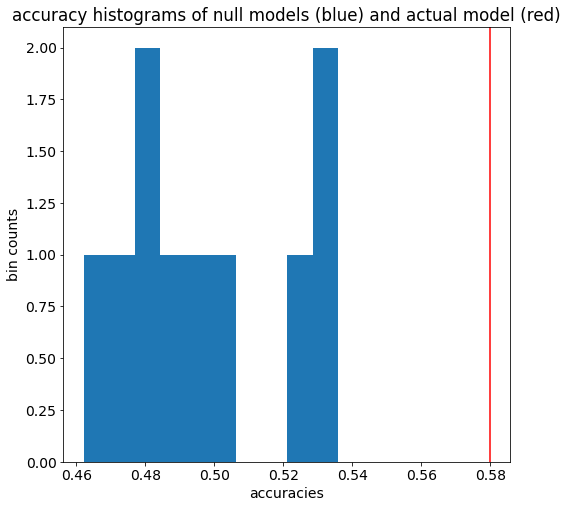

In [26]:
plt.hist(np.stack(null_eval_hists, axis=0))
plt.axvline(eval_hist[1], color='red')
plt.xlabel('accuracies')
plt.ylabel('bin counts')
plt.title('accuracy histograms of null models (blue) and actual model (red)')